In [99]:
import numpy as np
from keras import layers
from keras.layers import Input,Add,Dense,Activation,ZeroPadding2D,BatchNormalization,Flatten,Conv2D,AveragePooling2D,MaxPooling2D
from keras.models import Model,load_model
from keras.preprocessing import image
from keras.applications.imagenet_utils import preprocess_input
import pydot
from IPython.display import SVG
from keras.utils import plot_model
from keras.initializers import glorot_uniform
import pandas as pd
import matplotlib.pyplot as plt
import os
import cv2
from sklearn.utils import shuffle
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from PIL import Image

In [100]:
def identity_block(X,f,filters):
    # Retrieve Filters
    F1,F2,F3=filters
    X_shortcut=X
    # First layer
    X=Conv2D(filters=F1,kernel_size=(1,1),strides=(1,1),padding='valid')(X)
    X=BatchNormalization(axis=3)(X)
    X=Activation('relu')(X)
    # Second layer
    X=Conv2D(filters=F2,kernel_size=(f,f),strides=(1,1),padding='same')(X)
    X=BatchNormalization(axis=3)(X)
    X=Activation('relu')(X)
    # Third layer
    X=Conv2D(filters=F3,kernel_size=(1,1),strides=(1,1),padding='valid')(X)
    X=BatchNormalization(axis=3)(X)
    # Final step: Add shortcut value to F(X), and pass it through a RELU activation
    X=Add()([X,X_shortcut])
    X=Activation('relu')(X)
    return X

In [101]:
def convolutional_block(X,f,filters,s=2):
    # Retrieve Filters
    F1,F2,F3=filters
    # Save the input value
    X_shortcut=X
    # First layer
    X=Conv2D(F1,(1,1),strides=(s,s))(X) # 1,1 is filter size
    X=BatchNormalization(axis=3)(X) # Normalization on channels
    X=Activation('relu')(X)
    # Second layer (f,f)=3*3 filter by default
    X=Conv2D(filters=F2,kernel_size=(f,f),strides=(1,1),padding='same')(X)
    X=BatchNormalization(axis=3)(X)
    X=Activation('relu')(X)
    # Third layer
    X=Conv2D(filters=F3,kernel_size=(1,1),strides=(1,1),padding='valid')(X)
    X=BatchNormalization(axis=3)(X)
    # Shortcut path
    X_shortcut=Conv2D(filters=F3,kernel_size=(1,1),strides=(s,s),padding='valid')(X_shortcut)
    X=BatchNormalization(axis=3)(X_shortcut)
    # Final step: Add shortcut value here, and pass it through a RELU activation
    X=Add()([X,X_shortcut])
    X=Activation('relu')(X)
    return X

In [102]:
dataset_path=os.listdir('Xray_Classifier')
image_types=os.listdir('Xray_Classifier')
print(image_types)
print('Types of images found: ',len(image_types))

['non_xray', 'xray']
Types of images found:  2


In [103]:
images=[]
for item in image_types:
    all_images=os.listdir('Xray_Classifier'+'/'+item)
    for image in all_images:
        images.append((item,str('Xray_Classifier'+'/'+item)+'/'+image))

In [104]:
images[:10]

[('non_xray', 'Xray_Classifier/non_xray/2 (1).jpg'),
 ('non_xray', 'Xray_Classifier/non_xray/2 (10).jpg'),
 ('non_xray', 'Xray_Classifier/non_xray/2 (100).jpg'),
 ('non_xray', 'Xray_Classifier/non_xray/2 (101).jpg'),
 ('non_xray', 'Xray_Classifier/non_xray/2 (102).jpg'),
 ('non_xray', 'Xray_Classifier/non_xray/2 (103).jpg'),
 ('non_xray', 'Xray_Classifier/non_xray/2 (104).jpg'),
 ('non_xray', 'Xray_Classifier/non_xray/2 (105).jpg'),
 ('non_xray', 'Xray_Classifier/non_xray/2 (106).jpg'),
 ('non_xray', 'Xray_Classifier/non_xray/2 (107).jpg')]

In [105]:
images_df=pd.DataFrame(data=images,columns=['image types','image'])
print(images_df.head())

  image types                                 image
0    non_xray    Xray_Classifier/non_xray/2 (1).jpg
1    non_xray   Xray_Classifier/non_xray/2 (10).jpg
2    non_xray  Xray_Classifier/non_xray/2 (100).jpg
3    non_xray  Xray_Classifier/non_xray/2 (101).jpg
4    non_xray  Xray_Classifier/non_xray/2 (102).jpg


In [106]:
print('Total number of images in the dataset:',len(images_df))
print('========================================')
co=images_df['image types'].value_counts()
print('Images in each category:')
print(co)

Total number of images in the dataset: 600
Images in each category:
image types
non_xray    300
xray        300
Name: count, dtype: int64


In [107]:
X,y=[],[]
for i in images:
    img=i[1]
    img=cv2.imread(img)
    if img is None:
        print('Wrong path')
    else:
        resized_img=cv2.resize(img,(224,224))
        X.append(resized_img)
        y.append(i[0])

Wrong path


In [108]:
X[0]

array([[[203, 144,  97],
        [217, 142,  71],
        [214, 144,  73],
        ...,
        [102,  54,   1],
        [ 87,  44,   6],
        [ 76,  36,   4]],

       [[227, 184, 154],
        [200, 137,  73],
        [193, 125,  36],
        ...,
        [110,  63,   7],
        [109,  62,   9],
        [101,  58,   7]],

       [[235, 206, 190],
        [237, 190, 137],
        [187, 122,  24],
        ...,
        [113,  67,   7],
        [114,  69,   3],
        [112,  66,   1]],

       ...,

       [[ 92, 132, 174],
        [ 86, 127, 166],
        [ 88, 130, 166],
        ...,
        [ 62,  79,  96],
        [ 62,  77,  99],
        [ 62,  77,  99]],

       [[ 88, 128, 170],
        [ 88, 129, 168],
        [ 86, 128, 164],
        ...,
        [ 62,  76,  94],
        [ 63,  76,  97],
        [ 63,  76,  98]],

       [[ 90, 130, 172],
        [ 85, 126, 165],
        [ 82, 124, 160],
        ...,
        [ 56,  70,  88],
        [ 67,  81, 101],
        [ 55,  69,  88]]

In [109]:
y[:10]

['non_xray',
 'non_xray',
 'non_xray',
 'non_xray',
 'non_xray',
 'non_xray',
 'non_xray',
 'non_xray',
 'non_xray',
 'non_xray']

In [110]:
print(len(X))

599


In [111]:
print(len(y))

599


In [112]:
X=np.array(X)

In [113]:
X.shape

(599, 224, 224, 3)

In [114]:
X=X/255

In [115]:
X[0]

array([[[0.79607843, 0.56470588, 0.38039216],
        [0.85098039, 0.55686275, 0.27843137],
        [0.83921569, 0.56470588, 0.28627451],
        ...,
        [0.4       , 0.21176471, 0.00392157],
        [0.34117647, 0.17254902, 0.02352941],
        [0.29803922, 0.14117647, 0.01568627]],

       [[0.89019608, 0.72156863, 0.60392157],
        [0.78431373, 0.5372549 , 0.28627451],
        [0.75686275, 0.49019608, 0.14117647],
        ...,
        [0.43137255, 0.24705882, 0.02745098],
        [0.42745098, 0.24313725, 0.03529412],
        [0.39607843, 0.22745098, 0.02745098]],

       [[0.92156863, 0.80784314, 0.74509804],
        [0.92941176, 0.74509804, 0.5372549 ],
        [0.73333333, 0.47843137, 0.09411765],
        ...,
        [0.44313725, 0.2627451 , 0.02745098],
        [0.44705882, 0.27058824, 0.01176471],
        [0.43921569, 0.25882353, 0.00392157]],

       ...,

       [[0.36078431, 0.51764706, 0.68235294],
        [0.3372549 , 0.49803922, 0.65098039],
        [0.34509804, 0

In [116]:
X,y=shuffle(X,y,random_state=42)

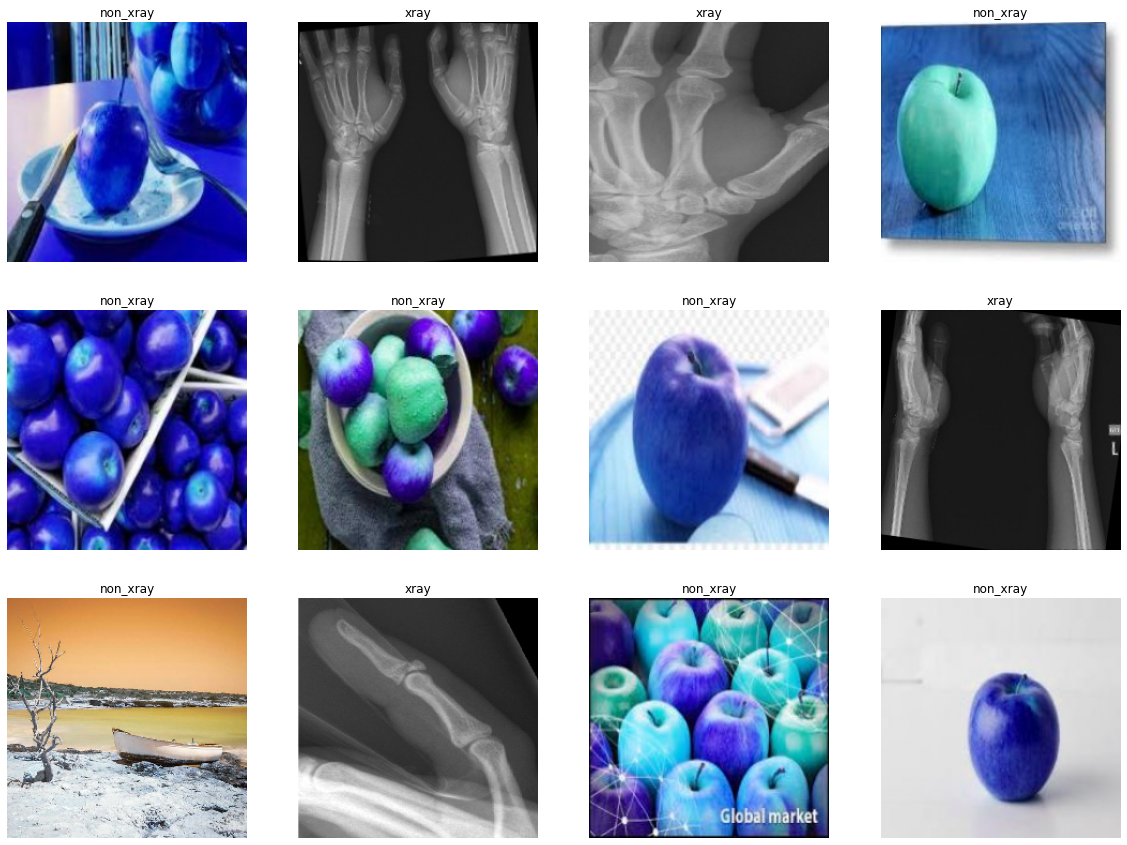

In [117]:
plt.figure(figsize=(20,15))
for i in range(0,12):
    ax=plt.subplot(3,4,i+1)
    plt.imshow(X[i])
    plt.title(y[i])
    plt.axis('off')

In [118]:
le=LabelEncoder()

In [119]:
y=le.fit_transform(y)

In [120]:
y[:10]

array([0, 1, 1, 0, 0, 0, 0, 1, 0, 1], dtype=int64)

In [121]:
X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.2,random_state=42,shuffle=True,stratify=y)

In [122]:
print(X_train.shape)

(479, 224, 224, 3)


In [123]:
print(X_test.shape)

(120, 224, 224, 3)


In [124]:
def ResNet50(input_shape=(224,224,3)):
    '''
    Implementation of the ResNet50 architecture:
    Conv2D -> BatchNorm -> MaxPool -> ConvBlock -> IDBlock*2 -> ConvBlock -> IDBlock*3
    -> ConvBlock -> IDBlock*5 -> ConvBlock -> IDBlock*2 -> AvgPool -> TopLayer
    '''
    # Define the input with shape input_shape
    X_input=Input(input_shape)
    # Zero-Padding
    X=ZeroPadding2D((3,3))(X_input) # 3,3 padding
    # Stage 1
    X=Conv2D(64,(7,7),strides=(2,2))(X)
    X=BatchNormalization(axis=3)(X)
    X=Activation('relu')(X)
    X=MaxPooling2D((3,3),strides=(2,2))(X)
    # Satge 2
    X=convolutional_block(X,f=3,filters=[64,64,256],s=1)
    X=identity_block(X,3,[64,64,256])
    X=identity_block(X,3,[64,64,256])
    # Stage 3
    X=convolutional_block(X,f=3,filters=[128,128,512],s=2)
    X=identity_block(X,3,[128,128,512])
    X=identity_block(X,3,[128,128,512])
    X=identity_block(X,3,[128,128,512])
    # Stage 4
    X=convolutional_block(X,f=3,filters=[256,256,1024],s=2)
    X=identity_block(X,3,[256,256,1024])
    X=identity_block(X,3,[256,256,1024])
    X=identity_block(X,3,[256,256,1024])
    X=identity_block(X,3,[256,256,1024])
    X=identity_block(X,3,[256,256,1024])
    # Stage 5
    X=convolutional_block(X,f=3,filters=[512,512,2048],s=2)
    X=identity_block(X,3,[512,512,2048])
    X=identity_block(X,3,[512,512,2048])
    # AvgPool
    X=AveragePooling2D((2,2),name='avg_pool')(X)
    # Output layer
    X=Flatten()(X)
    X=Dense(1,activation='sigmoid',name='fc',kernel_initializer=glorot_uniform(seed=0))(X)
    # Create model
    model=Model(inputs=X_input,outputs=X,name='ResNet50')
    return model

In [125]:
model=ResNet50(input_shape=(224,224,3))

In [126]:
model.compile(optimizer='adam',
             loss='binary_crossentropy',
             metrics=['accuracy'])

In [127]:
model.summary()

Model: "ResNet50"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                  ┃ Output Shape              ┃         Param # ┃ Connected to               ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_2 (InputLayer)    │ (None, 224, 224, 3)       │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ zero_padding2d_2              │ (None, 230, 230, 3)       │               0 │ input_layer_2[0][0]        │
│ (ZeroPadding2D)               │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2d_106 (Conv2D)           │ (None, 112, 112, 64)      │           9,472 │ zero_padding2d_2[0][0]     │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ batch_normalization_106       │ (None, 112, 112, 64)      │             256 │ conv2d_106[0][0]           │
│ (BatchNormalization)          │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ activation_98 (Activation)    │ (None, 112, 112, 64)      │               0 │ batch_normalization_106[0… │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ max_pooling2d_2               │ (None, 55, 55, 64)        │               0 │ activation_98[0][0]        │
│ (MaxPooling2D)                │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2d_110 (Conv2D)           │ (None, 55, 55, 256)       │          16,640 │ max_pooling2d_2[0][0]      │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ batch_normalization_110       │ (None, 55, 55, 256)       │           1,024 │ conv2d_110[0][0]           │
│ (BatchNormalization)          │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ add_32 (Add)                  │ (None, 55, 55, 256)       │               0 │ batch_normalization_110[0… │
│                               │                           │                 │ conv2d_110[0][0]           │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ activation_101 (Activation)   │ (None, 55, 55, 256)       │               0 │ add_32[0][0]               │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2d_111 (Conv2D)           │ (None, 55, 55, 64)        │          16,448 │ activation_101[0][0]       │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ batch_normalization_111       │ (None, 55, 55, 64)        │             256 │ conv2d_111[0][0]           │
│ (BatchNormalization)          │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ activation_102 (Activation)   │ (None, 55, 55, 64)        │               0 │ batch_normalization_111[0… │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2d_112 (Conv2D)           │ (None, 55, 55, 64)        │          36,928 │ activation_102[0][0]       │
├───────────────────────────────┼───────────────────────────┼───────────────

 Total params: 18,359,041 (70.03 MB)

 Trainable params: 18,317,441 (69.88 MB)

 Non-trainable params: 41,600 (162.50 KB)

In [128]:
model.fit(X_train,y_train,epochs=3,batch_size=32)

Epoch 1/3
15/15 ━━━━━━━━━━━━━━━━━━━━ 479s 14s/step - accuracy: 0.7709 - loss: 6.4308
Epoch 2/3
15/15 ━━━━━━━━━━━━━━━━━━━━ 203s 12s/step - accuracy: 0.9812 - loss: 0.0405
Epoch 3/3
15/15 ━━━━━━━━━━━━━━━━━━━━ 204s 14s/step - accuracy: 0.9921 - loss: 0.0236


In [129]:
preds=model.evaluate(X_test,y_test)
print('Loss:',preds[0])
print('Accuracy:',preds[1])

4/4 ━━━━━━━━━━━━━━━━━━━━ 40s 3s/step - accuracy: 0.6325 - loss: 0.6173
Loss: 0.6241539716720581
Accuracy: 0.6333333253860474
